In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.dates as dt
import pandas as pd
import scipy.stats as sc

from matplotlib import rc #for Latex plot labeling

Upload the data. Everything in $.
Training data:  01.02.2010 - 30.01.2015
Backtesting data: 01.02.2015 - 19.05.2022

In [2]:
visa_data_raw = open("C:\\...\\Visa.csv")
visa_data = csv.reader(visa_data_raw)
ma_data_raw = open("C:\\...\\MA.csv")
ma_data = csv.reader(ma_data_raw)


visa_data_backtest = csv.reader(open("C:\\...\\Visa(2015-2022).csv"))
MA_data_backtest = csv.reader(open("C:\\...\\MA(2015-2022).csv"))

Format the data. 
The data format is:
['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

In [3]:
def cleandata(data):
    """ 
    Averages high and low for each day.
    Convertes date.
    """
    rows= []
    for row in data:
        rows.append(row)
    rows = rows[1:]    
    quotes = []
    dates = []
    for row in rows:
        quotes.append((float(row[2])+float(row[3]))/2) #averaging highs and lows (see above line about format)
        dates.append(row[0])
    dates = pd.to_datetime(dates).date #converting the data into pandas data format (so it makes a nice plot later on)
    return(np.array(dates), np.array(quotes))
def normed_quotes(quotes):

    """
    converts quotes to relative change. Afterwards we have the precentage increase relative to 
    the first date. Or growth of a single dollar.
    """
    price_t0 = quotes[0] #quotes[0] is the average price of the first day
    quotes_normed = [i/price_t0 for i in quotes] #norming to the first day
    return(np.array(quotes_normed))

def marketshare(x_quotes,y_quotes):
    """
    relative market share of two assets. Returns market weights vector.
    """
    return(np.array([x_quotes/(x_quotes+y_quotes), y_quotes/(x_quotes+y_quotes)]))

In [4]:
[dates, visa_quotes] = cleandata(visa_data)
[dates, ma_quotes] = cleandata(ma_data)

visa_quotes = normed_quotes(visa_quotes)
ma_quotes = normed_quotes(ma_quotes)

market_weights = marketshare(visa_quotes, ma_quotes)

#the same for the backtesting data

[dates_b, visa_quotes_back] = cleandata(visa_data_backtest)
[dates_b, ma_quotes_back] = cleandata(MA_data_backtest)

visa_rel_back = normed_quotes(visa_quotes_back)
ma_rel_back = normed_quotes(ma_quotes_back)

market_weights_back = marketshare(visa_rel_back, ma_rel_back)

first component is Visa second MA

We also "normed" the data. That means the market weights reflect the growth of a single dollar investment into each stock.

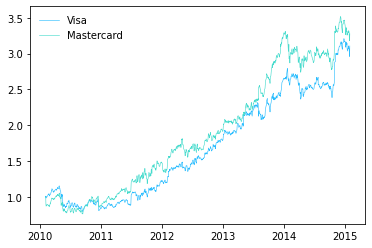

In [5]:
plt.plot(dates, visa_quotes, label = "Visa", linewidth=0.6, color = '#2CBDFE')
plt.plot(dates, ma_quotes, label = "Mastercard", linewidth = 0.6, color = '#47DBCD');
plt.legend(frameon = False);
#plt.savefig('filename.pdf')

We calculate theta (the exponential coordiante of the market weight).
The simplex is in 2d, i.e. a 1d manifold, theta is accordingly a real number.  

In [6]:
theta = np.log(market_weights[0]/market_weights[1]) #formula from the paper

theta_back = np.log(market_weights_back[0]/market_weights_back[1])

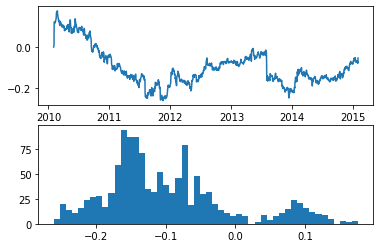

In [7]:
plt.subplot(211)
fig3 = plt.plot(dates, theta)
plt.subplot(212)
plt.hist(theta, bins = 50);

Theta seems to be bimodal. To simplify the whole process, we just fit theta as a normal distribution

In [8]:
mean = np.mean(theta)
std = np.std(theta)

P = sc.norm(mean, std)

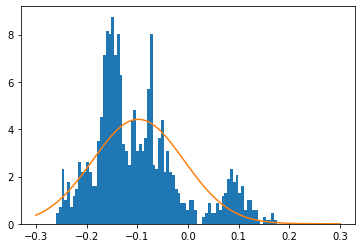

In [9]:
xx = np.linspace(-0.3,0.3,500)
plt.hist(theta, bins = 80, density = True) #need "density = True" here, otherwise the historam cant be fitted by prob. distr.
plt.plot(xx, P.pdf(xx));

In [10]:
print(mean, std) 

-0.09799720404553212 0.09029239459088527


**Case 1:** $Q$ is normal

In [11]:
m2 = 0
s2 = 0.045 #compared to P, small variance (less than half)
Q1 = sc.norm(m2, s2) 

We define the portfolio with the method from the paper

In [12]:
def normal_portfolio(mu_1, m1, m2, s1, s2):
    """
    This is just the portfolio function for two normal distributions. Also taken from the paper.
    """
    mu_2 = 1 - mu_1.copy()
    alpha = 1- s2/s1
    c = np.exp(m1*s2/s1 - m2)
    pi_1 = []
    pi_2 = []
    for i in range(len(mu_1)):
        denom = c*mu_1[i]**alpha + mu_2[i]**alpha
        pi_1.append(c*mu_1[i]**alpha/denom)
        pi_2.append(mu_2[i]**alpha / denom)
    return pi_1,pi_2

We can now backtest the portfolio.

In [13]:
mu = market_weights_back

pi1 = normal_portfolio(mu[0], mean, m2, std, s2)

Define the relative return

In [14]:
def V(mu, pi, alpha = 1):
    """
    Returns array with relative value for each time period.
    alpha -> for trading cost. Each period (1-alpha)V(t) trading cost
    """
    V = []
    V.append(1.0)
    V_t = 1.0
    for i in range(len(mu[0])-1):
        V_t = V_t*(pi[0][i] * mu[0][i+1]/mu[0][i] + pi[1][i] * mu[1][i+1]/mu[1][i]) #The relative value function from the paper
        V_t = V_t*alpha
        V.append(V_t)
    return V

We calculate the relative return for the portfolio and the buy and hold strategy (i.e. the market). The latter should be constant 1: the relative value of the market to the market is trivially 1.

In [15]:
V_generated = V(mu,pi1)
V_hold = V(mu, mu) #Buy and Hold relative return pi = mu

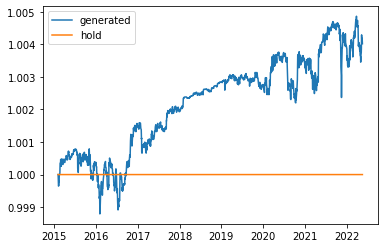

In [16]:
plt.plot(dates_b, V_generated, label = "generated")
plt.plot(dates_b, V_hold, label = "hold")
plt.legend();

We now choose some different $Q$

First calculate the transport map for the general case

G is cdf of P = N(p1,s1)

H is cdf of Q

In [17]:
#std configuration: a = -7, b = 7, n = 5000
def F(x, G ,H , a=-1 ,b=0.8 , n = 10000):
    """
    G,H - distribution functions
    [a,b] - intervall in which we look for the correct value
    n - how fine the search for the value should be
    
    Calculates intersection of H(z) and y = G(x) over all z in [a,b]. 
    Does not work in full generality for all distributions, so one needs to be a little careful.
    After testing the function a little it is also clear that there can be quite a bit of error.
    
    Coding idea from https://stackoverflow.com/questions/28766692/intersection-of-two-graphs-in-python-find-the-x-value
    """
    
    if type(x) == float: #small modification so we can also use simple floats to test the function.
        x = [x*1.0]
    ret = []
    xx = np.linspace(a,b,n)
    for i in x:
        z = G(i)
        x_index = np.argwhere(np.diff(np.sign(z - H(xx)))).flatten() #looking for changes of sign in the difference of the functions (i.e. an intersection)
        if len(x_index) == 0:
            x_index = np.array([0]) #if no intersection is found, return minimum point a.
        ret.append(xx[x_index][0]) #take index 0 because thats the first i.e. lowest intersection
    return ret

In [18]:
def iota_invers(theta): 
    """
    The inverse coordinate chart iota.
    """
    psi = np.log(1 + np.exp(theta))
    return np.array([np.exp(theta - psi), np.exp(- psi)])

The portfolio is then given by: 

$
\pi(\iota^{-1}(\theta))  = \iota^{-1}(\theta - F(\theta)),
$

where $\theta$ is the exponential coordinate.

**Case 2**: Q is uniform on some intervall [a,b]

In [19]:
def uniform_dist(x,a,b):
    ret = []
    for i in x:
        if i >= a and i <= b:
            ret.append(1/(b-a))
        else:
            ret.append(0.0)
    return ret

In [20]:
def uniform_cdf(x,a=0,b=1):
    """
    Cdf of the uniform distribution on [a,b].
    
    Takes only arrays
    """
    ret = []
    for i in range(len(x)):
        if x[i] > b or x[i] < a:
            ret.append(0.0)
        else:
            ret.append((x[i]-a)/(b-a))
    return ret

In [21]:
def uniform_portfolio(x, m1, s1, a,b):
    """
    P = N(m1,s1)
    [a,b] is the intervall of the uniform distribution
    """
    f_output = F(x, sc.norm(m1,s1).cdf, lambda x: uniform_cdf(x,a,b)) #use above equation for the portfolio pi.
    pi = iota_invers(np.subtract(x, f_output))
    return pi

In [22]:
a = -0.1
b = 0.3
Q2 = lambda x: uniform_dist(x, a, b)

mu = market_weights_back
pi2 = uniform_portfolio(theta_back, mean, std, a, b) #high runtime, because F is so unoptimized.

In [23]:
V_generated2 = V(mu,pi2)
V_hold = V(mu, mu) #Buy and Hold relative return pi = mu

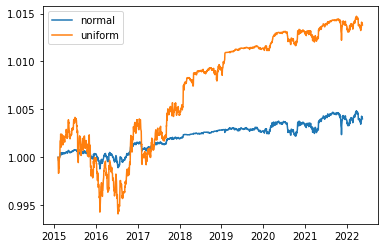

In [24]:
plt.plot(dates_b, V_generated, label = "normal")
plt.plot(dates_b, V_generated2, label = "uniform")
#plt.plot(dates_b, V_hold, label = "hold")
plt.legend();

**Case 3**: Q is the Laplace distribution.

Analagously we can calculate the portoflio for the laplace distribution.

In [25]:
def laplace_dist(x, loc, scale):
    return 1/(2*scale) * np.exp(- np.absolute(x-loc)/scale)
        

In [26]:
def laplace_cdf(x, loc, scale):
    ret = []
    for i in x:
        if i <= loc:
            ret.append(1/2 *np.exp((i-loc)/scale))
        else:
            ret.append(1 - 1/2 *np.exp(-(i-loc)/scale))
    return ret

In [27]:
loc = -0.1
scale = 0.15

In [28]:
Q3 = lambda x: laplace_dist(x, loc, scale)

In [29]:
def laplace_portfolio(x, m1,s1, loc, scale): 
    f_output = F(x, sc.norm(m1,s1).cdf, lambda x: laplace_cdf(x,loc,scale))
    pi = iota_invers(np.subtract(x, f_output))
    return pi   

In [30]:
mu = market_weights_back
pi3 = uniform_portfolio(theta_back, mean, std, loc, scale)

In [31]:
V_generated3 = V(mu,pi3)
V_hold = V(mu, mu) #Buy and Hold relative return pi = mu

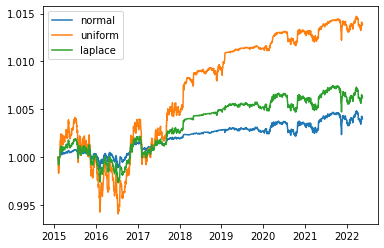

In [32]:
plt.plot(dates_b, V_generated, label = "normal")
plt.plot(dates_b, V_generated2, label = "uniform")
plt.plot(dates_b, V_generated3, label = "laplace")
#plt.plot(dates_b, V_hold, label = "hold")
plt.legend();

Below we see the portfolio weights of the first asset with regard to the its market weight.

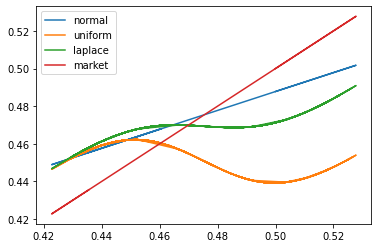

In [33]:
plt.plot(mu[0], pi1[0], label = "normal")
plt.plot(mu[0], pi2[0], label = "uniform")
plt.plot(mu[0], pi3[0], label = "laplace")
plt.plot(mu[0], mu[0], label = "market")
plt.legend();

In [34]:
rc('text', usetex=True)

In [35]:
xn = np.linspace(0.4,0.55, 100)
test_weights = np.array([xn, 1-xn])
theta_test = np.log(test_weights[0]/test_weights[1])

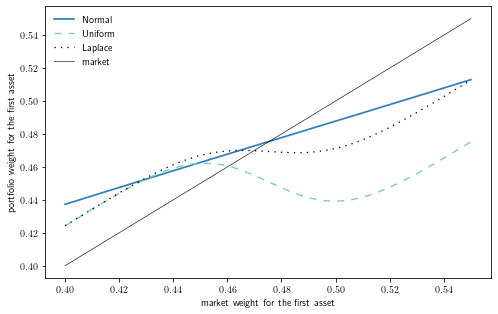

In [36]:
#choose in F: a=-1 ,b=0.8 , n = 10000
plt.figure(figsize = (8,5))
pi1_test = normal_portfolio(xn, mean, m2, std, s2)
pi2_test = uniform_portfolio(theta_test, mean, std, a, b)
pi3_test = uniform_portfolio(theta_test, mean, std, loc, scale)

plt.plot(xn, pi1_test[0], color = "#2c7fb8", label = "Normal", linewidth = 1.7)
plt.plot(xn, pi2_test[0], color = '#7fcdbb', label = "Uniform", linewidth = 1.4, linestyle = "dashed", dashes=(5, 5))
plt.plot(xn, pi3_test[0], color = 'black', label = "Laplace", linewidth = 1.3, ls=":", dashes=(1,4,1,4))
plt.plot(xn, xn, label = "market", color = "black", linewidth = 0.6)
plt.legend(frameon = False);
plt.xlabel("market weight for the first asset")
plt.ylabel("portfolio weight for the first asset");
plt.savefig('application2.pdf',bbox_inches='tight')

We implement trading costs

In [37]:
alpha = 0.99999
1-0.00001
0.00001*100

0.001

We assume trading costs to be 0,001% per trade.
For each t, the relative value V(t) losses 0,001%.

In [38]:
V_generated_tc = V(mu,pi1, alpha)

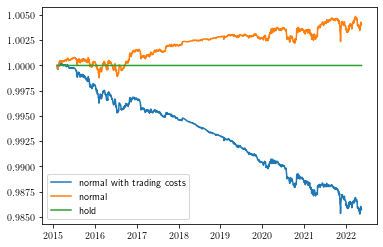

In [39]:
plt.plot(dates_b, V_generated_tc, label = "normal with trading costs")
plt.plot(dates_b, V_generated, label = "normal")
plt.plot(dates_b, V_hold, label = "hold")
plt.legend();

We already dont outperform the market anymore.

In [40]:
V_generated2_tc = V(mu,pi2, alpha)

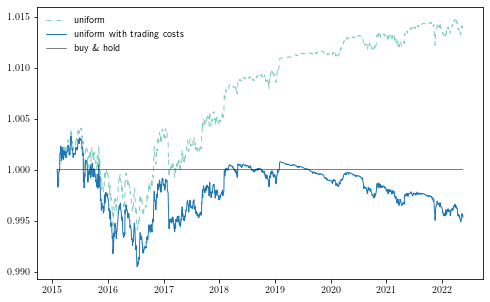

In [41]:
plt.figure(figsize = (8,5))
plt.plot(dates_b, V_generated2, color = '#7fcdbb', label = "uniform", linewidth = 1, linestyle = "dashed", dashes=(5, 5))
plt.plot(dates_b, V_generated2_tc, label = "uniform with trading costs", linewidth = 1)
plt.plot(dates_b, V_hold, color = "black", label = "buy \& hold", linewidth = 0.5)
plt.legend(frameon = False);
plt.savefig('application4.pdf',bbox_inches='tight')

Plots: 

training period 1$, time series theta, theta/P densitiy fitting, Q densities

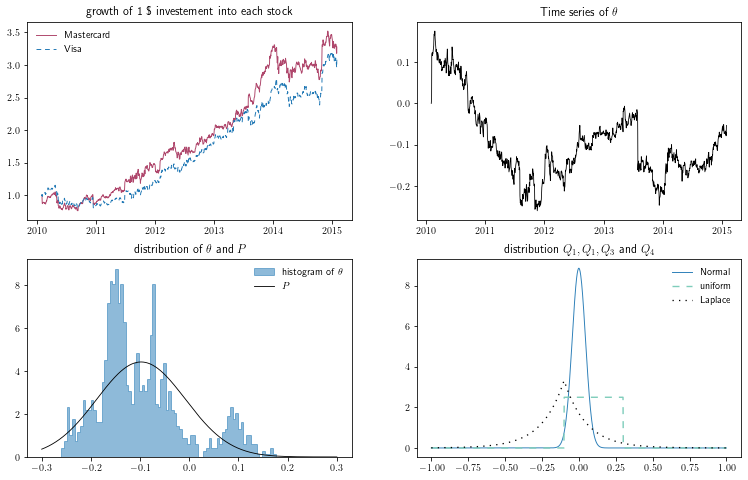

In [42]:
fig = plt.figure(figsize = (12.8,8))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)


ax1.title.set_text(r"growth of 1 \$ investement into each stock")
ax1.plot(dates, ma_quotes, label = "Mastercard", linewidth = 0.95, color = '#af476c')
ax1.plot(dates, visa_quotes, label = "Visa", linewidth=0.95, linestyle = "dashed", dashes=(5, 4))
ax1.legend(frameon = False)

ax2.title.set_text(r"Time series of $\theta$") #need r before string to signify its raw text, otherwise \theta doesnt work
ax2.plot(dates, theta, color = 'black', linewidth = .8)    
xx1 = np.linspace(-0.3,0.3,500)

ax3.title.set_text(r"distribution of $\theta$ and $P$")
ax3.hist(theta, bins = 80, density = True, alpha = 0.5, label = r"histogram of $\theta$", histtype = 'step', fill = True) #need "density = True" here, otherwise the historam cant be fitted by prob. distr.
ax3.plot(xx1, P.pdf(xx1), color = 'black', linestyle = "solid", label = "$P$", linewidth = 0.85)
ax3.legend(frameon = False)

xx2 = np.linspace(-1,1,1000)
ax4.title.set_text(r"distribution $Q_1, Q_1, Q_3$ and $Q_4$")
ax4.plot(xx2, Q1.pdf(xx2), label = "Normal", linewidth = 0.95, color = "#2c7fb8")
ax4.plot(xx2, Q2(xx2), color = '#7fcdbb', label = "uniform", linewidth = 1.4, linestyle = "dashed", dashes=(5, 5))
ax4.plot(xx2, Q3(xx2), color = 'black', label = "Laplace", linewidth = 1.3, ls=":", dashes=(1,4,1,4))
ax4.legend(frameon = False)

plt.savefig('application1.pdf',bbox_inches='tight')

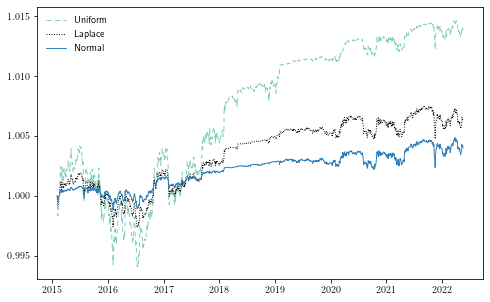

In [43]:
plt.figure(figsize = (8,5))
plt.plot(dates_b,V_generated2, color = '#7fcdbb', label = "Uniform", linewidth = 0.95, linestyle = "dashed", dashes=(5, 4))
plt.plot(dates_b, V_generated3, color = 'black', label = "Laplace", linewidth = 0.95, linestyle = ":")
plt.plot(dates_b, V_generated,color = "#2c7fb8", label = "Normal", linewidth = 0.95)
#plt.plot(dates_b, V_hold, label = "hold")
plt.legend(frameon = False);
plt.savefig('application3.pdf',bbox_inches='tight')